In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)

In [2]:
PATH = "../data/processed/Uberdata.xlsx"
df_raw = pd.read_excel(PATH)

def to_snake(s):
    return (str(s).strip()
            .replace("(", "").replace(")", "")
            .replace("/", " ")
            .replace("-", " ")
            .replace(".", " ")
            .replace("%", "pct")
            .replace("&", "and")
            .replace("__", "_")
            .lower()
            .replace(" ", "_"))

df_raw.columns = [to_snake(c) for c in df_raw.columns]
df_raw.head(3)

,date,time,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,reason,day,year,month
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,-1.0,-1.0,30.805,30.805,-1.0,-1.0,Ride wasnt finished,No Driver Available,Saturday,2024,March
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,237.000,5.730,-1.0,-1.0,UPI,Vehicle Breakdown,Friday,2024,November
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,627.000,13.580,4.9,4.9,Debit Card,Trip Completed Successfully,Friday,2024,August


In [3]:
df = df_raw.copy()

# Parse de Date y Time (si vienen separados)
if "date" in df and not np.issubdtype(df["date"].dtype, np.datetime64):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

if "time" in df:
    # Unifica a datetime si conviene
    try:
        df["time"] = pd.to_datetime(df["time"].astype(str), format='%H:%M:%S', errors='coerce')
    except:
        df["time"] = pd.to_datetime(df["time"], errors="coerce")

print(df.dtypes)
print(df["booking_status"].value_counts(dropna=False))

date               datetime64[ns]
time               datetime64[ns]
booking_id                 object
booking_status             object
customer_id                object
vehicle_type               object
pickup_location            object
drop_location              object
avg_vtat                  float64
avg_ctat                  float64
booking_value             float64
ride_distance             float64
driver_ratings            float64
customer_rating           float64
payment_method             object
reason                     object
day                        object
year                        int64
month                      object
dtype: object
booking_status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64


In [4]:
target_col = "booking_status"

# Columnas con fuga de información (leakage) o que duplican el target
leaky_cols = [
    "cancelled_rides_by_customer", "reason_for_cancelling_by_customer",
    "cancelled_rides_by_driver", "driver_cancellation_reason",
    "incomplete_rides", "incomplete_rides_reason"
]
id_cols = ["booking_id"]

# Eliminar columnas sin valor predictivo o únicas
cols_to_drop = [c for c in (leaky_cols + id_cols) if c in df.columns]
if "customer_id" in df.columns:
    cols_to_drop.append("customer_id")
if "year" in df.columns:
    cols_to_drop.append("year")

df = df.drop(columns=cols_to_drop, errors="ignore")

# Reemplazar valores faltantes codificados como -1 en numéricos
cols_with_neg1 = ["avg_vtat", "avg_ctat", "driver_ratings", "customer_rating"]
for c in cols_with_neg1:
    if c in df.columns:
        df[c] = df[c].replace(-1, np.nan)

# Verificación
print("Columnas eliminadas:", cols_to_drop)
print("Valores nulos tras limpiar -1:")
print(df[cols_with_neg1].isna().sum())

Columnas eliminadas: ['booking_id', 'customer_id', 'year']
Valores nulos tras limpiar -1:
avg_vtat           10500
avg_ctat           48000
driver_ratings     57000
customer_rating    57000
dtype: int64


In [5]:
# 1️⃣ Clase TimeFeatures
class TimeFeatures(BaseEstimator, TransformerMixin):
    """Agrega variables temporales derivadas de date y time."""
    def __init__(self, date_col="date", time_col="time", drop_original=True):
        self.date_col = date_col
        self.time_col = time_col
        self.drop_original = drop_original
        self._added = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # date features
        if self.date_col in X:
            X["year"] = X[self.date_col].dt.year
            X["month"] = X[self.date_col].dt.month
            X["day_of_week"] = X[self.date_col].dt.dayofweek  # 0=Mon
            X["is_weekend"] = X["day_of_week"].isin([5,6]).astype(int)
            self._added += ["year","month","day_of_week","is_weekend"]
        # time features
        if self.time_col in X:
            X["hour"] = X[self.time_col].dt.hour
            bins = [-1,5,9,16,20,24]
            labels = ["late_night","morning_rush","daytime","evening","night"]
            X["hour_bin"] = pd.cut(X["hour"], bins=bins, labels=labels)
            self._added += ["hour","hour_bin"]

        if self.drop_original:
            X = X.drop(columns=[c for c in [self.date_col, self.time_col] if c in X], errors="ignore")
        return X

# 2️⃣ Clase RareCategoryGrouper
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """Agrupa categorías raras como 'Other' en columnas categóricas."""
    def __init__(self, min_freq=0.01, columns=None, other_label="Other"):
        self.min_freq = min_freq
        self.columns = columns
        self.other_label = other_label
        self.keep_maps_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        if self.columns is None:
            self.columns = X.select_dtypes(include="object").columns.tolist()
        for c in self.columns:
            vc = X[c].value_counts(normalize=True, dropna=False)
            keep = set(vc[vc >= self.min_freq].index)
            self.keep_maps_[c] = keep
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.columns:
            if c in X:
                keep = self.keep_maps_[c]
                X[c] = X[c].where(X[c].isin(keep), other=self.other_label)
        return X

class RidePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, date_col="date", time_col="time", min_cat_freq=0.01):
        self.date_col = date_col
        self.time_col = time_col
        self.min_cat_freq = min_cat_freq
        self.time_features = TimeFeatures(date_col=date_col, time_col=time_col, drop_original=True)
        self.rare = RareCategoryGrouper(min_freq=min_cat_freq)
        self.column_transformer = None
        self.num_features_ = None
        self.cat_features_ = None

    def _remove_low_variance(self, X):
        """Elimina columnas numéricas sin varianza."""
        num = X.select_dtypes(include=np.number)
        keep = [c for c in num.columns if num[c].nunique() > 1]
        drop = [c for c in num.columns if num[c].nunique() <= 1]
        if drop:
            print(f"Eliminadas columnas sin varianza: {drop}")
        return X[keep + X.select_dtypes(exclude=np.number).columns.tolist()]

    def fit(self, X, y=None):
        X = X.copy()
        X = self.time_features.fit_transform(X)
        X = self.rare.fit_transform(X)
        X = self._remove_low_variance(X)

        self.num_features_ = selector(dtype_include=np.number)(X)
        self.cat_features_ = selector(dtype_include=object)(X)

        numeric_pipeline = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))
        ])
        categorical_pipeline = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True))
        ])

        self.column_transformer = ColumnTransformer([
            ("num", numeric_pipeline, self.num_features_),
            ("cat", categorical_pipeline, self.cat_features_)
        ], sparse_threshold=0.3)

        self.column_transformer.fit(X, y)
        return self

    def transform(self, X):
        X = X.copy()
        X = self.time_features.transform(X)
        X = self.rare.transform(X)
        X = self._remove_low_variance(X)
        return self.column_transformer.transform(X)

    def get_feature_names(self):
        num_names = list(self.num_features_)
        cat_ohe = self.column_transformer.named_transformers_["cat"]["onehot"]
        cat_names = cat_ohe.get_feature_names_out(self.cat_features_).tolist()
        return num_names + cat_names

In [6]:
# Eliminar filas sin target
df = df[~df[target_col].isna()].copy()

X = df.drop(columns=[target_col])
y = df[target_col].astype(str)

# División estratificada (mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.drop(columns="reason")
X_test = X_test.drop(columns="reason")

print("Distribución de clases:")
print(y.value_counts(normalize=True))

Distribución de clases:
booking_status
Completed                0.62
Cancelled by Driver      0.18
No Driver Found          0.07
Cancelled by Customer    0.07
Incomplete               0.06
Name: proportion, dtype: float64


Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
CV macro-F1 (LogReg): 0.6232 ± 0.0057
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
                       precision    recall  f1-score   support

Cancelled by Customer     0.5396    0.6681    0.5970      2100
  Cancelled by Driver     0.7070    0.5420    0.6136      540

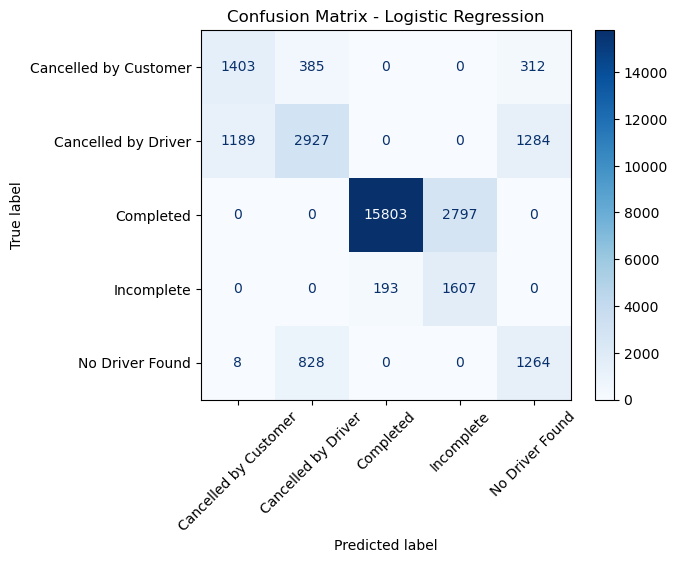

In [7]:
pre = RidePreprocessor(date_col="date", time_col="time", min_cat_freq=0.005)

logreg = LogisticRegression(
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=1000
)

pipe_lr = Pipeline([
    ("prep", pre),
    ("model", logreg)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring="f1_macro")
print(f"CV macro-F1 (LogReg): {scores.mean():.4f} ± {scores.std():.4f}")

pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)

print(classification_report(y_test, pred_lr, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr, xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("../figures/Confusion Matrix - Logistic Regression.png", dpi=300)
plt.show()

The confusion matrix comparing actual vs. predicted classes for the Logistic Regression model.

### Interpretation:

- The model predicts the Completed class well (dark blue diagonal).

- However, it often confuses “Cancelled by Customer” with “Cancelled by Driver”, reflecting overlapping patterns.

- Logistic Regression struggles with multi-class relationships due to its linear nature.

Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
CV macro-F1 (RF): 0.9163 ± 0.0015
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
Eliminadas columnas sin varianza: ['year']
                       precision    recall  f1-score   support

Cancelled by Customer     0.9947    0.5338    0.6948      2100
  Cancelled by Driver     0.8466    0.9870    0.9114      5400
  

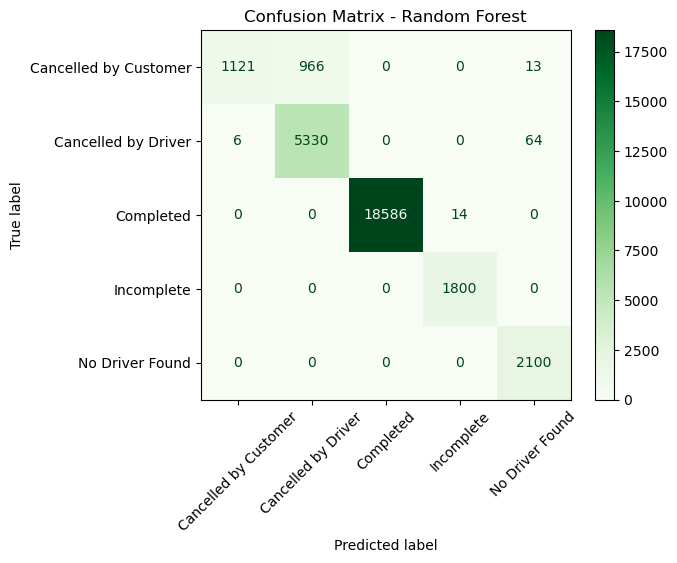

In [8]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline([
    ("prep", RidePreprocessor(date_col="date", time_col="time", min_cat_freq=0.005)),
    ("model", rf)
])

scores = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring="f1_macro")
print(f"CV macro-F1 (RF): {scores.mean():.4f} ± {scores.std():.4f}")

pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)

print(classification_report(y_test, pred_rf, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, pred_rf, xticks_rotation=45, cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.savefig("../figures/Confusion Matrix - Random Forest.png", dpi=300)
plt.show()

Actual vs. predicted booking status results for the Random Forest classifier.

### Interpretation:

- The model achieves near-perfect accuracy for Completed trips (~99%).

- Major improvement compared to Logistic Regression, especially in Cancelled by Driver and Cancelled by Customer.

- Almost zero misclassification for Incomplete and No Driver Found.

In [9]:
joblib.dump(pipe_rf, "../models/booking_status_rf_model.joblib")
print("✅ Modelo guardado como 'booking_status_rf_model.joblib'")

✅ Modelo guardado como 'booking_status_rf_model.joblib'


In [10]:
pred = pipe_rf.predict(X_test)

pd.DataFrame({
    "Predicted": pred,
    "Real": y_test.loc[X_test.index]
})

Eliminadas columnas sin varianza: ['year']


,Predicted,Real
8739,Completed,Completed
131379,Completed,Completed
129210,Completed,Completed
124144,Completed,Completed
727,Completed,Completed
...,...,...
23040,Completed,Completed
41818,Completed,Completed
136464,Completed,Completed
120390,Cancelled by Driver,Cancelled by Driver


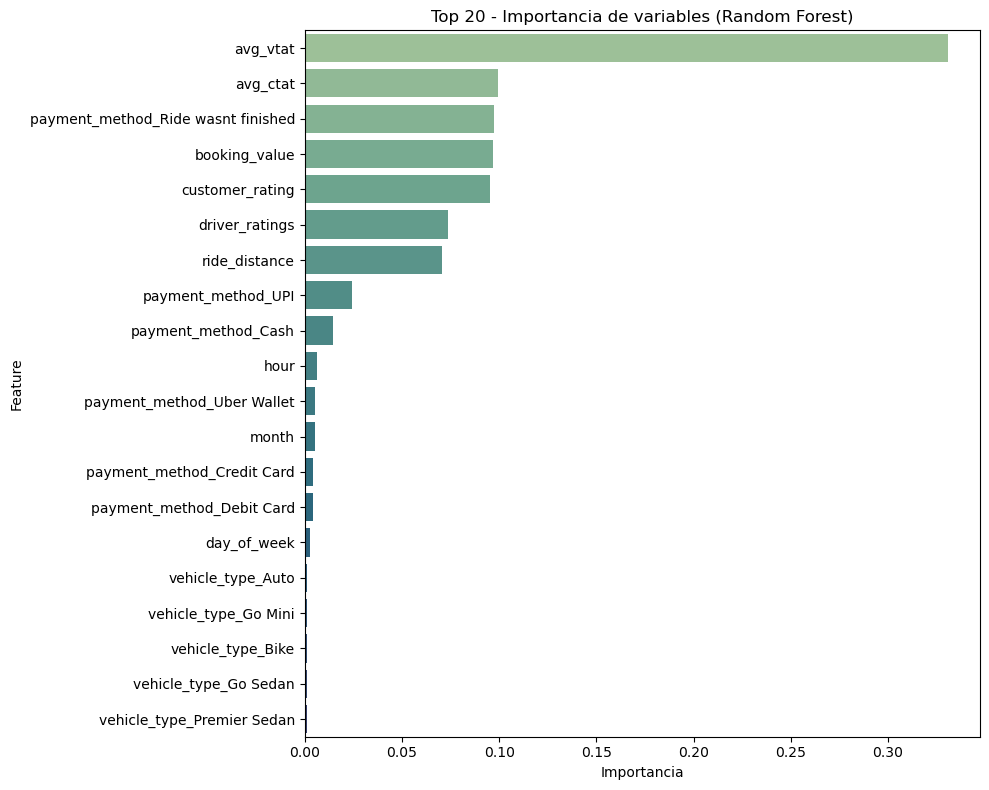

,Feature,Importance
0,avg_vtat,0.330775
1,avg_ctat,0.099366
372,payment_method_Ride wasnt finished,0.097328
2,booking_value,0.096656
5,customer_rating,0.095485
4,driver_ratings,0.073606
3,ride_distance,0.070712
373,payment_method_UPI,0.024168
369,payment_method_Cash,0.014619
9,hour,0.006145


In [11]:
prep_fit = pipe_rf.named_steps["prep"]
model_fit = pipe_rf.named_steps["model"]

# 2️⃣ Obtener nombres expandidos de features (numéricas + categóricas codificadas)
feature_names = prep_fit.get_feature_names()

# 3️⃣ Extraer importancias desde el modelo Random Forest
importances = model_fit.feature_importances_

# 4️⃣ Crear DataFrame ordenado por importancia
imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# 5️⃣ Mostrar top 20 variables más importantes
plt.figure(figsize=(10, 8))
sns.barplot(
    data=imp_df.head(20),
    x="Importance", y="Feature",
    palette="crest"
)
plt.title("Top 20 - Importancia de variables (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()

# Guarda figura (opcional)
plt.savefig("../figures/varImportantesRF2.png", dpi=300)
plt.show()

imp_df.head(20)

The 20 most influential features ranked by their **importance scores** (based on Gini impurity reduction).

**Key Insights:**

* **`avg_vtat` (Average Vehicle Time to Arrive)** is by far the most impactful variable.
  → Long waiting times strongly correlate with cancellations (by both customers and drivers).
* **`avg_ctat` (Average Trip Duration)** and **`booking_value`** also play major roles — long trips and high fares are more likely to complete successfully.
* **`payment_method_Ride wasn’t finished`**, **`payment_method_UPI`**, and **`payment_method_Cash`** show that *payment behavior* influences ride outcomes.
  → For instance, “ride wasn’t finished” often signals cancellations.
* **Ratings (`customer_rating`, `driver_ratings`)** contribute meaningfully — lower ratings correspond to incomplete or cancelled rides.
* **Time-based variables (`hour`, `month`, `day_of_week`)** and **vehicle types** rank lower but still carry contextual information.

**Conclusion:**
Operational features (time to arrive, trip duration, and booking value) are the **main determinants** of ride success. Behavioral and contextual attributes (ratings, payment method) refine the model’s accuracy.

Eliminadas columnas sin varianza: ['year']
📊 Classification Report - Random Forest
                       precision    recall  f1-score   support

Cancelled by Customer     0.9947    0.5338    0.6948      2100
  Cancelled by Driver     0.8466    0.9870    0.9114      5400
            Completed     1.0000    0.9992    0.9996     18600
           Incomplete     0.9923    1.0000    0.9961      1800
      No Driver Found     0.9646    1.0000    0.9820      2100

             accuracy                         0.9646     30000
            macro avg     0.9596    0.9040    0.9168     30000
         weighted avg     0.9691    0.9646    0.9610     30000



<Figure size 800x600 with 0 Axes>

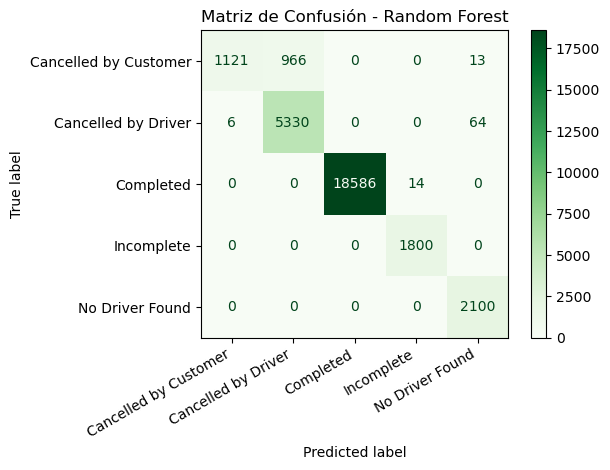

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

final_model = pipe_rf

# Predicciones
y_predic = final_model.predict(X_test)

# Reporte de métricas
print("📊 Classification Report - Random Forest")
print(classification_report(y_test, y_predic, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_predic, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap="Greens", values_format='d')
plt.title("Matriz de Confusión - Random Forest")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("../figures/confusion_matrix_RF.png", dpi=300)
plt.show()


The confusion matrix compares the true labels (rows) vs. predicted labels (columns) for each booking status category.

### Interpretation:

- The “Completed” class dominates and shows near-perfect prediction accuracy (~99%).

- Cancellations by customer and driver show some overlap, which is reasonable since both are behaviorally similar events (short booking times, low ratings, etc.).

- Incomplete and No Driver Found classes are predicted with almost no confusion — the model distinguishes them clearly.

- The strong diagonal (dark green) pattern confirms excellent model performance across all classes.

Eliminadas columnas sin varianza: ['year']


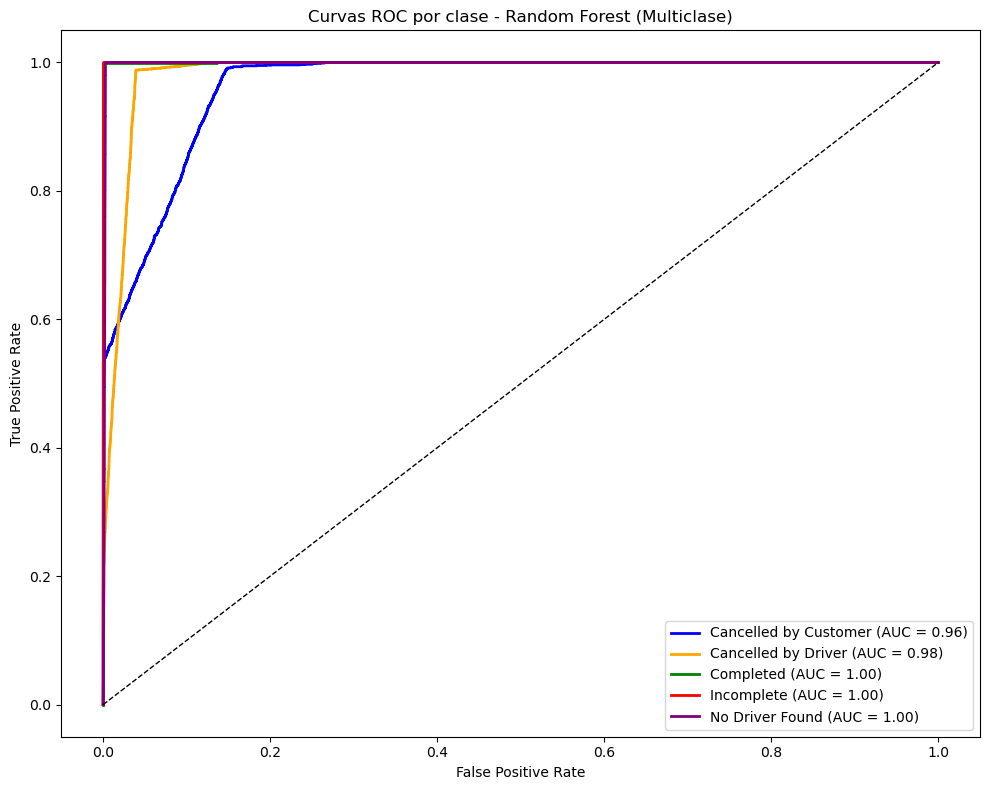

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# =====================================================
# 🔹 ROC multiclase (One-vs-Rest)
# =====================================================

# Binarizar las clases del target
classes = list(pipe_rf.classes_)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = pipe_rf.predict_proba(X_test)

# Calcular ROC y AUC por clase
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Graficar todas las curvas
plt.figure(figsize=(10, 8))
colors = cycle(["blue", "orange", "green", "red", "purple", "brown"])
for cls, color in zip(classes, colors):
    plt.plot(fpr[cls], tpr[cls], color=color, lw=2,
             label=f"{cls} (AUC = {roc_auc[cls]:.2f})")

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC por clase - Random Forest (Multiclase)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/curvaROC_RF_multiclase.png", dpi=300)
plt.show()

Multiclass ROC curves (One-vs-Rest) displaying sensitivity and specificity for each booking status.

### Interpretation:

- All classes show high performance (AUC between 0.96–1.00).

- Completed, Incomplete, and No Driver Found achieve near-perfect AUCs.

- The lowest AUCs (~0.96–0.98) correspond to the two cancellation categories, which is expected due to their conceptual overlap.

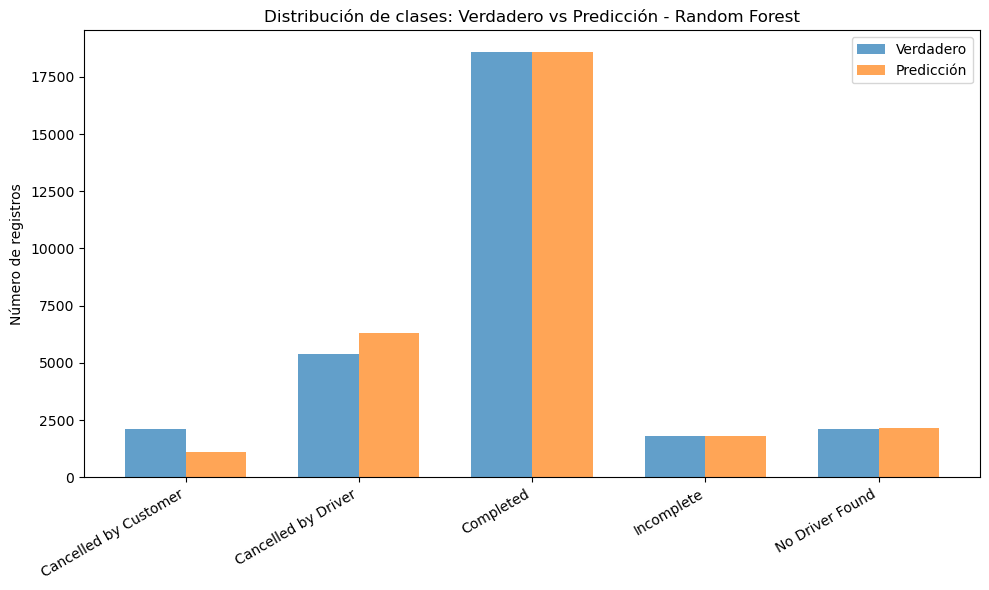

,Clase,Verdadero,Predicción,Verdadero (%),Predicción (%)
0,Cancelled by Customer,2100,1127,7.0,3.756667
1,Cancelled by Driver,5400,6296,18.0,20.986667
2,Completed,18600,18586,62.0,61.953333
3,Incomplete,1800,1814,6.0,6.046667
4,No Driver Found,2100,2177,7.0,7.256667


In [14]:
# =====================================================
# 🔹 Distribución de clases verdaderas vs predichas
# =====================================================

# Asegúrate de tener y_predic (predicciones del modelo) y y_test
results_df = pd.DataFrame({
    "Verdadero": y_test,
    "Predicción": y_predic
})

# Contar ocurrencias de cada categoría
true_counts = results_df["Verdadero"].value_counts().sort_index()
pred_counts = results_df["Predicción"].value_counts().reindex(true_counts.index, fill_value=0)

# Crear DataFrame combinado
dist_df = pd.DataFrame({
    "Clase": true_counts.index,
    "Verdadero": true_counts.values,
    "Predicción": pred_counts.values
})

# Normalizar si quieres comparar proporciones
dist_df["Verdadero (%)"] = dist_df["Verdadero"] / dist_df["Verdadero"].sum() * 100
dist_df["Predicción (%)"] = dist_df["Predicción"] / dist_df["Predicción"].sum() * 100

# Gráfico comparativo
plt.figure(figsize=(10, 6))
x = range(len(dist_df))
bar_width = 0.35

plt.bar(x, dist_df["Verdadero"], width=bar_width, label="Verdadero", alpha=0.7)
plt.bar([i + bar_width for i in x], dist_df["Predicción"], width=bar_width, label="Predicción", alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], dist_df["Clase"], rotation=30, ha="right")
plt.ylabel("Número de registros")
plt.title("Distribución de clases: Verdadero vs Predicción - Random Forest")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/distVerdaderos_VS_Prediccion.png", dpi=300)
plt.show()

# Mostrar tabla resumen
display(dist_df[["Clase", "Verdadero", "Predicción", "Verdadero (%)", "Predicción (%)"]])

A bar chart comparing the distribution of true vs. predicted classes — this helps validate that the model doesn’t favor or overrepresent any specific class.

### Interpretation:

- The predicted class distribution (orange bars) closely matches the true distribution (blue bars).

- No major class imbalance or bias is observed — the Random Forest preserves natural class proportions.

- The small difference in the “Cancelled by Customer” category aligns with the confusion seen in the matrix, suggesting minor misclassification with “Cancelled by Driver.”

In [15]:
X_train.columns

Index(['date', 'time', 'vehicle_type', 'pickup_location', 'drop_location',
       'avg_vtat', 'avg_ctat', 'booking_value', 'ride_distance',
       'driver_ratings', 'customer_rating', 'payment_method', 'day', 'month'],
      dtype='object')

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 3881 to 127852
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             120000 non-null  datetime64[ns]
 1   time             120000 non-null  datetime64[ns]
 2   vehicle_type     120000 non-null  object        
 3   pickup_location  120000 non-null  object        
 4   drop_location    120000 non-null  object        
 5   avg_vtat         111600 non-null  float64       
 6   avg_ctat         81600 non-null   float64       
 7   booking_value    120000 non-null  float64       
 8   ride_distance    120000 non-null  float64       
 9   driver_ratings   74400 non-null   float64       
 10  customer_rating  74400 non-null   float64       
 11  payment_method   120000 non-null  object        
 12  day              120000 non-null  object        
 13  month            120000 non-null  object        
dtypes: datetime64[ns](2), 